# BMI Status Prediction
  
  <br/><br/>
 

This notebook contains preparatory steps to create a simple machine learning model for use with a **Flask** API.  
I downloaded the original dataset from [this](https://www.kaggle.com/datasets/mustafa20635/fitness-exercises-using-bfp-and-bmi/data) Kaggle page and, after processing the data and running some basic EDA, exported the final model as a pickle file.  

  
  <br/><br/>
  

## Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import warnings
import glob
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

In [4]:
import joblib

In [5]:
# run to avoid warnings
warnings.filterwarnings('ignore')

In [6]:
# create a dataframe from the original fitness dataset
data = pd.read_csv('datasets/_original/final_dataset_BFP.csv')

In [7]:
data

,Weight,Height,BMI,Body Fat Percentage,BFPstatus,Gender,Age,BMIstatus,Exercise Recommendation Plan
0,76.811975,1.820521,23.175956,18.281148,Acceptable,Male,29,normal,4
1,77.721154,1.945498,20.534184,13.731021,Fitness,Male,23,normal,4
2,87.558726,1.742754,28.828859,42.304631,Obese,Female,57,over weight,5
3,89.473356,1.758318,28.940017,27.958021,Obese,Male,41,over weight,5
4,69.963943,1.722570,23.578732,16.464478,Fitness,Male,19,normal,4
...,...,...,...,...,...,...,...,...,...
4995,87.003054,1.902891,24.027404,16.772884,Fitness,Male,18,normal,4
4996,92.121555,1.779346,29.096464,30.215757,Obese,Male,50,over weight,5
4997,105.298845,1.972883,27.053345,31.214014,Obese,Male,65,over weight,5
4998,90.411999,1.803409,27.799528,29.579434,Obese,Male,54,over weight,5


In [8]:
data.isnull().any()

Weight                          False
Height                          False
BMI                             False
Body Fat Percentage             False
BFPstatus                       False
Gender                          False
Age                             False
BMIstatus                       False
Exercise Recommendation Plan    False
dtype: bool

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Weight                        5000 non-null   float64
 1   Height                        5000 non-null   float64
 2   BMI                           5000 non-null   float64
 3   Body Fat Percentage           5000 non-null   float64
 4   BFPstatus                     5000 non-null   object 
 5   Gender                        5000 non-null   object 
 6   Age                           5000 non-null   int64  
 7   BMIstatus                     5000 non-null   object 
 8   Exercise Recommendation Plan  5000 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 351.7+ KB


In [10]:
data.describe(include='all')

,Weight,Height,BMI,Body Fat Percentage,BFPstatus,Gender,Age,BMIstatus,Exercise Recommendation Plan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000,5000.000000,5000,5000.000000
unique,NaN,NaN,NaN,NaN,4,2,NaN,7,NaN
top,NaN,NaN,NaN,NaN,Obese,Male,NaN,normal,NaN
freq,NaN,NaN,NaN,NaN,3033,2517,NaN,1458,NaN
mean,80.218232,1.762564,26.003673,29.974650,NaN,NaN,41.769400,NaN,4.866000
std,17.161304,0.128635,5.601313,10.804125,NaN,NaN,13.797199,NaN,1.503095
min,50.004559,1.391627,13.099716,5.180450,NaN,NaN,18.000000,NaN,1.000000
25%,65.691294,1.704281,21.575751,21.296533,NaN,NaN,30.000000,NaN,4.000000
50%,80.178376,1.775016,26.565933,29.976548,NaN,NaN,42.000000,NaN,5.000000
75%,94.964977,1.846296,30.801344,39.128578,NaN,NaN,54.000000,NaN,6.000000


## Data Cleaning and Processing

In [11]:
# subset the original dataset
df = data[['Weight', 'Height', 'BFPstatus', 'Gender', 'Age', 'BMIstatus']]

In [12]:
# rename columns
df.rename(columns={'BFPstatus': 'BFP_Status', 'BMIstatus': 'BMI_Status'}, inplace=True)

In [13]:
df

,Weight,Height,BFP_Status,Gender,Age,BMI_Status
0,76.811975,1.820521,Acceptable,Male,29,normal
1,77.721154,1.945498,Fitness,Male,23,normal
2,87.558726,1.742754,Obese,Female,57,over weight
3,89.473356,1.758318,Obese,Male,41,over weight
4,69.963943,1.722570,Fitness,Male,19,normal
...,...,...,...,...,...,...
4995,87.003054,1.902891,Fitness,Male,18,normal
4996,92.121555,1.779346,Obese,Male,50,over weight
4997,105.298845,1.972883,Obese,Male,65,over weight
4998,90.411999,1.803409,Obese,Male,54,over weight


In [14]:
# convert Height to centimeters
df['Height'] = df['Height'] * 100

In [15]:
# convert Weight and Height to integers after rounding
df['Weight'] = df['Weight'].round().apply(np.int64)
df['Height'] = df['Height'].round().apply(np.int64)

In [16]:
# display BFP_Status values
df['BFP_Status'].unique()

array(['Acceptable', 'Fitness', 'Obese', 'Athletes'], dtype=object)

In [17]:
# display BMI_Status values
df['BMI_Status'].unique()

array(['normal', 'over weight', 'sever thinness', 'severe obese', 'obese',
       'mild thinness', 'moderate thinness'], dtype=object)

In [18]:
# map Gender to encoded values
df['Gender'] = df['Gender'].map({'Female' : 1,
                                 'Male'   : 0})


# map BFP_Status to encoded values
df['BFP_Status'] = df['BFP_Status'].map({'Athletes'   : 3,
                                         'Fitness'    : 2,
                                         'Acceptable' : 1,
                                         'Obese'      : 0})

# map BMI_Status to encoded values
df['BMI_Status'] = df['BMI_Status'].map({'sever thinness'    : 6,
                                         'moderate thinness' : 5,
                                         'mild thinness'     : 4,
                                         'normal'            : 3,
                                         'over weight'       : 2,
                                         'obese'             : 1,
                                         'severe obese'      : 0})

In [19]:
df

,Weight,Height,BFP_Status,Gender,Age,BMI_Status
0,77,182,1,0,29,3
1,78,195,2,0,23,3
2,88,174,0,1,57,2
3,89,176,0,0,41,2
4,70,172,2,0,19,3
...,...,...,...,...,...,...
4995,87,190,2,0,18,3
4996,92,178,0,0,50,2
4997,105,197,0,0,65,2
4998,90,180,0,0,54,2


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Weight      5000 non-null   int64
 1   Height      5000 non-null   int64
 2   BFP_Status  5000 non-null   int64
 3   Gender      5000 non-null   int64
 4   Age         5000 non-null   int64
 5   BMI_Status  5000 non-null   int64
dtypes: int64(6)
memory usage: 234.5 KB


In [21]:
df.describe()

,Weight,Height,BFP_Status,Gender,Age,BMI_Status
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,80.215400,176.260400,0.608200,0.496600,41.769400,2.134000
std,17.169379,12.871353,0.888398,0.500038,13.797199,1.503095
min,50.000000,139.000000,0.000000,0.000000,18.000000,0.000000
25%,66.000000,170.000000,0.000000,0.000000,30.000000,1.000000
50%,80.000000,177.500000,0.000000,0.000000,42.000000,2.000000
75%,95.000000,185.000000,1.000000,1.000000,54.000000,3.000000
max,110.000000,198.000000,3.000000,1.000000,65.000000,6.000000


In [22]:
# save the dataframe as CSV
df.to_csv('datasets/df.csv', encoding='utf-8', index=False)

## Exploratory Data Analysis

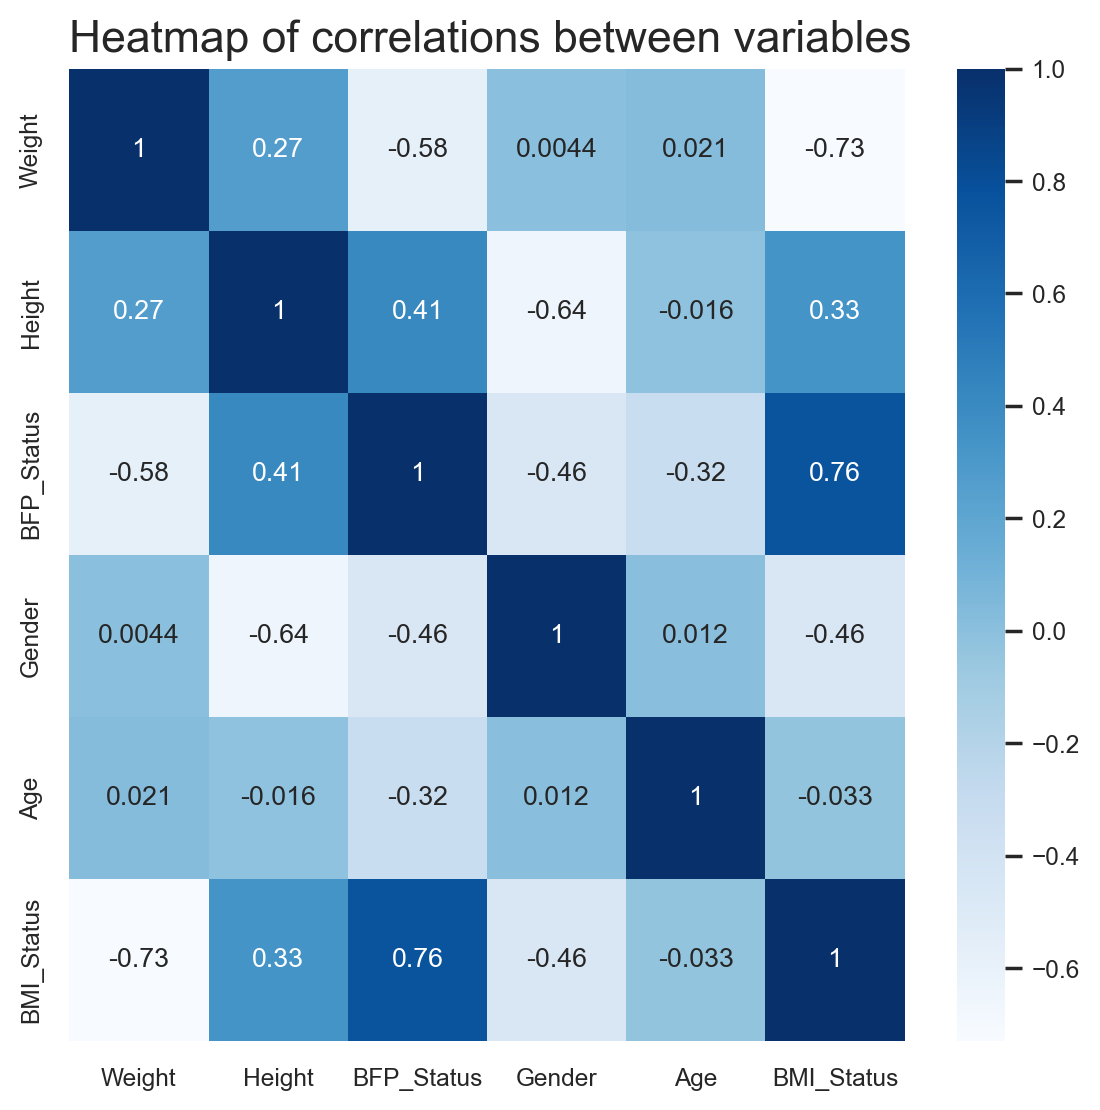

In [23]:
# plot heatmap about correlations between variables
plt.figure(figsize=(6, 6))
plt.title('Heatmap of correlations between variables', loc='left', fontsize = 16)
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.show()

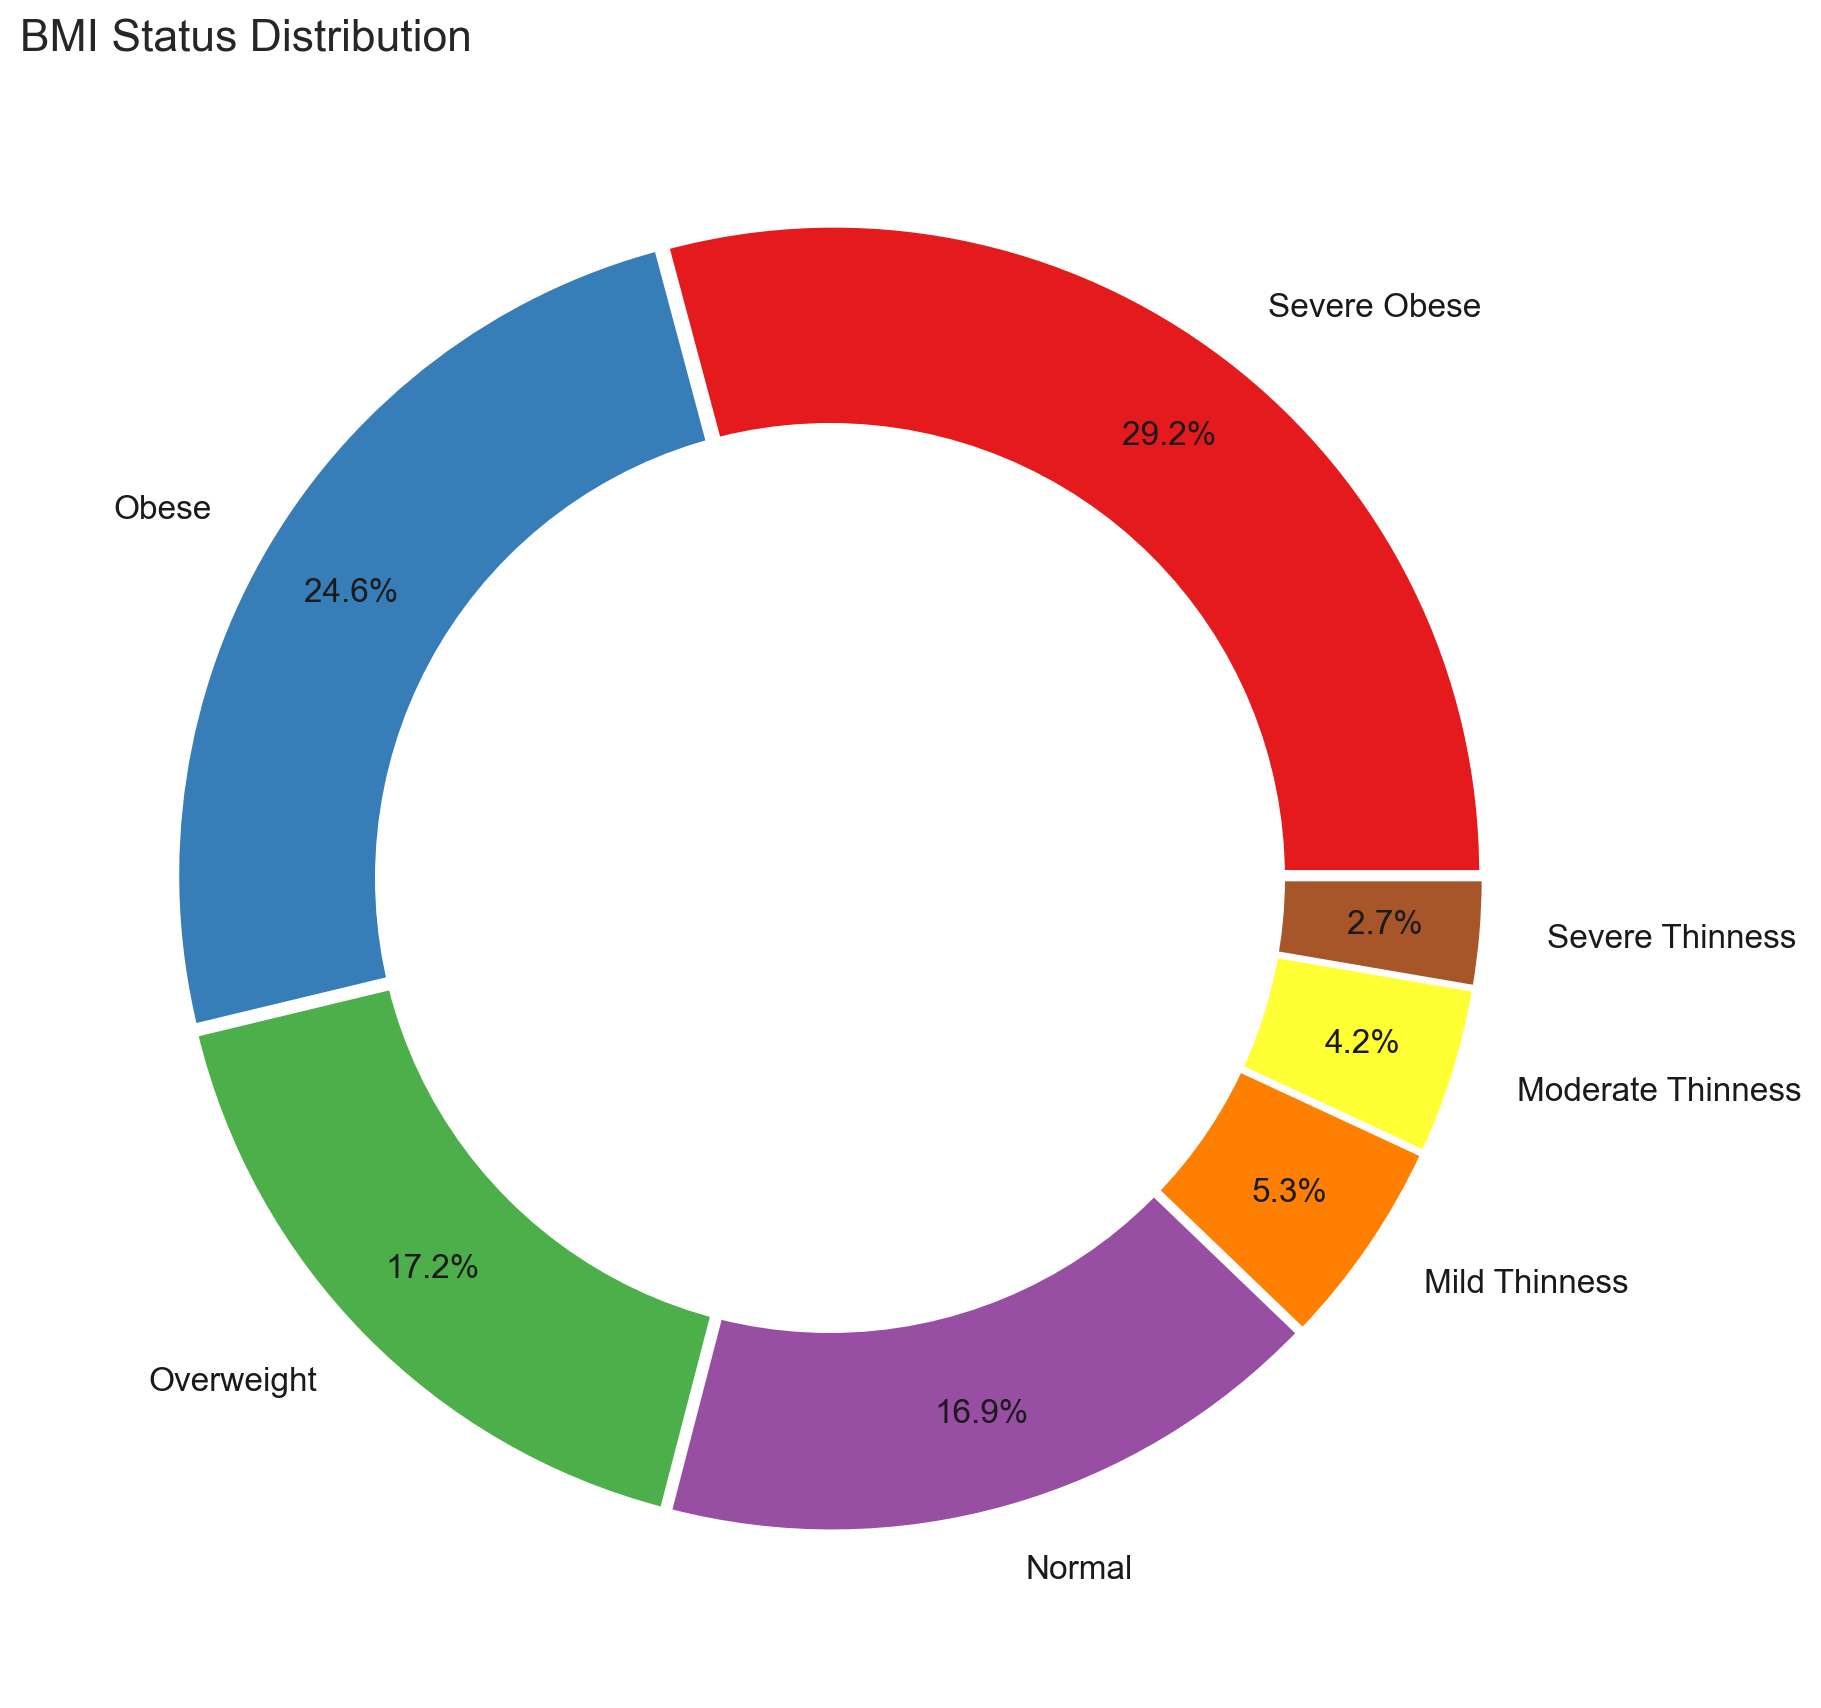

In [24]:
# plot donut chart about BMI status distribution
fig = plt.figure(figsize=(10,10))
plt.title('BMI Status Distribution', loc='left', fontsize = 16)
plt.xticks([]) # to disable xticks
plt.yticks([]) # to disable yticks

categories = df['BMI_Status'].value_counts()

explode = (0.01,)*(len(categories))
wedges, texts, autotexts =  plt.pie(categories,
                                    radius=1,
                                    explode=explode,
                                    labels=['Severe Obese', 'Obese', 'Overweight', 'Normal', 'Mild Thinness',
                                            'Moderate Thinness', 'Severe Thinness'],
                                    colors=sns.color_palette('Set1'),
                                    autopct="%1.1f%%",
                                    pctdistance=0.85,
                                    textprops=dict(color='k'),
                                    wedgeprops = { 'linewidth': 2, 'edgecolor': 'w' }
                                    )
plt.setp(autotexts,size=12)
plt.setp(texts,size=12)

# draw inner circle
centre_circle = plt.Circle((0,0), 0.7, color='white')
fig = plt.gcf()

# add inner circle
fig.gca().add_artist(centre_circle)

plt.show()

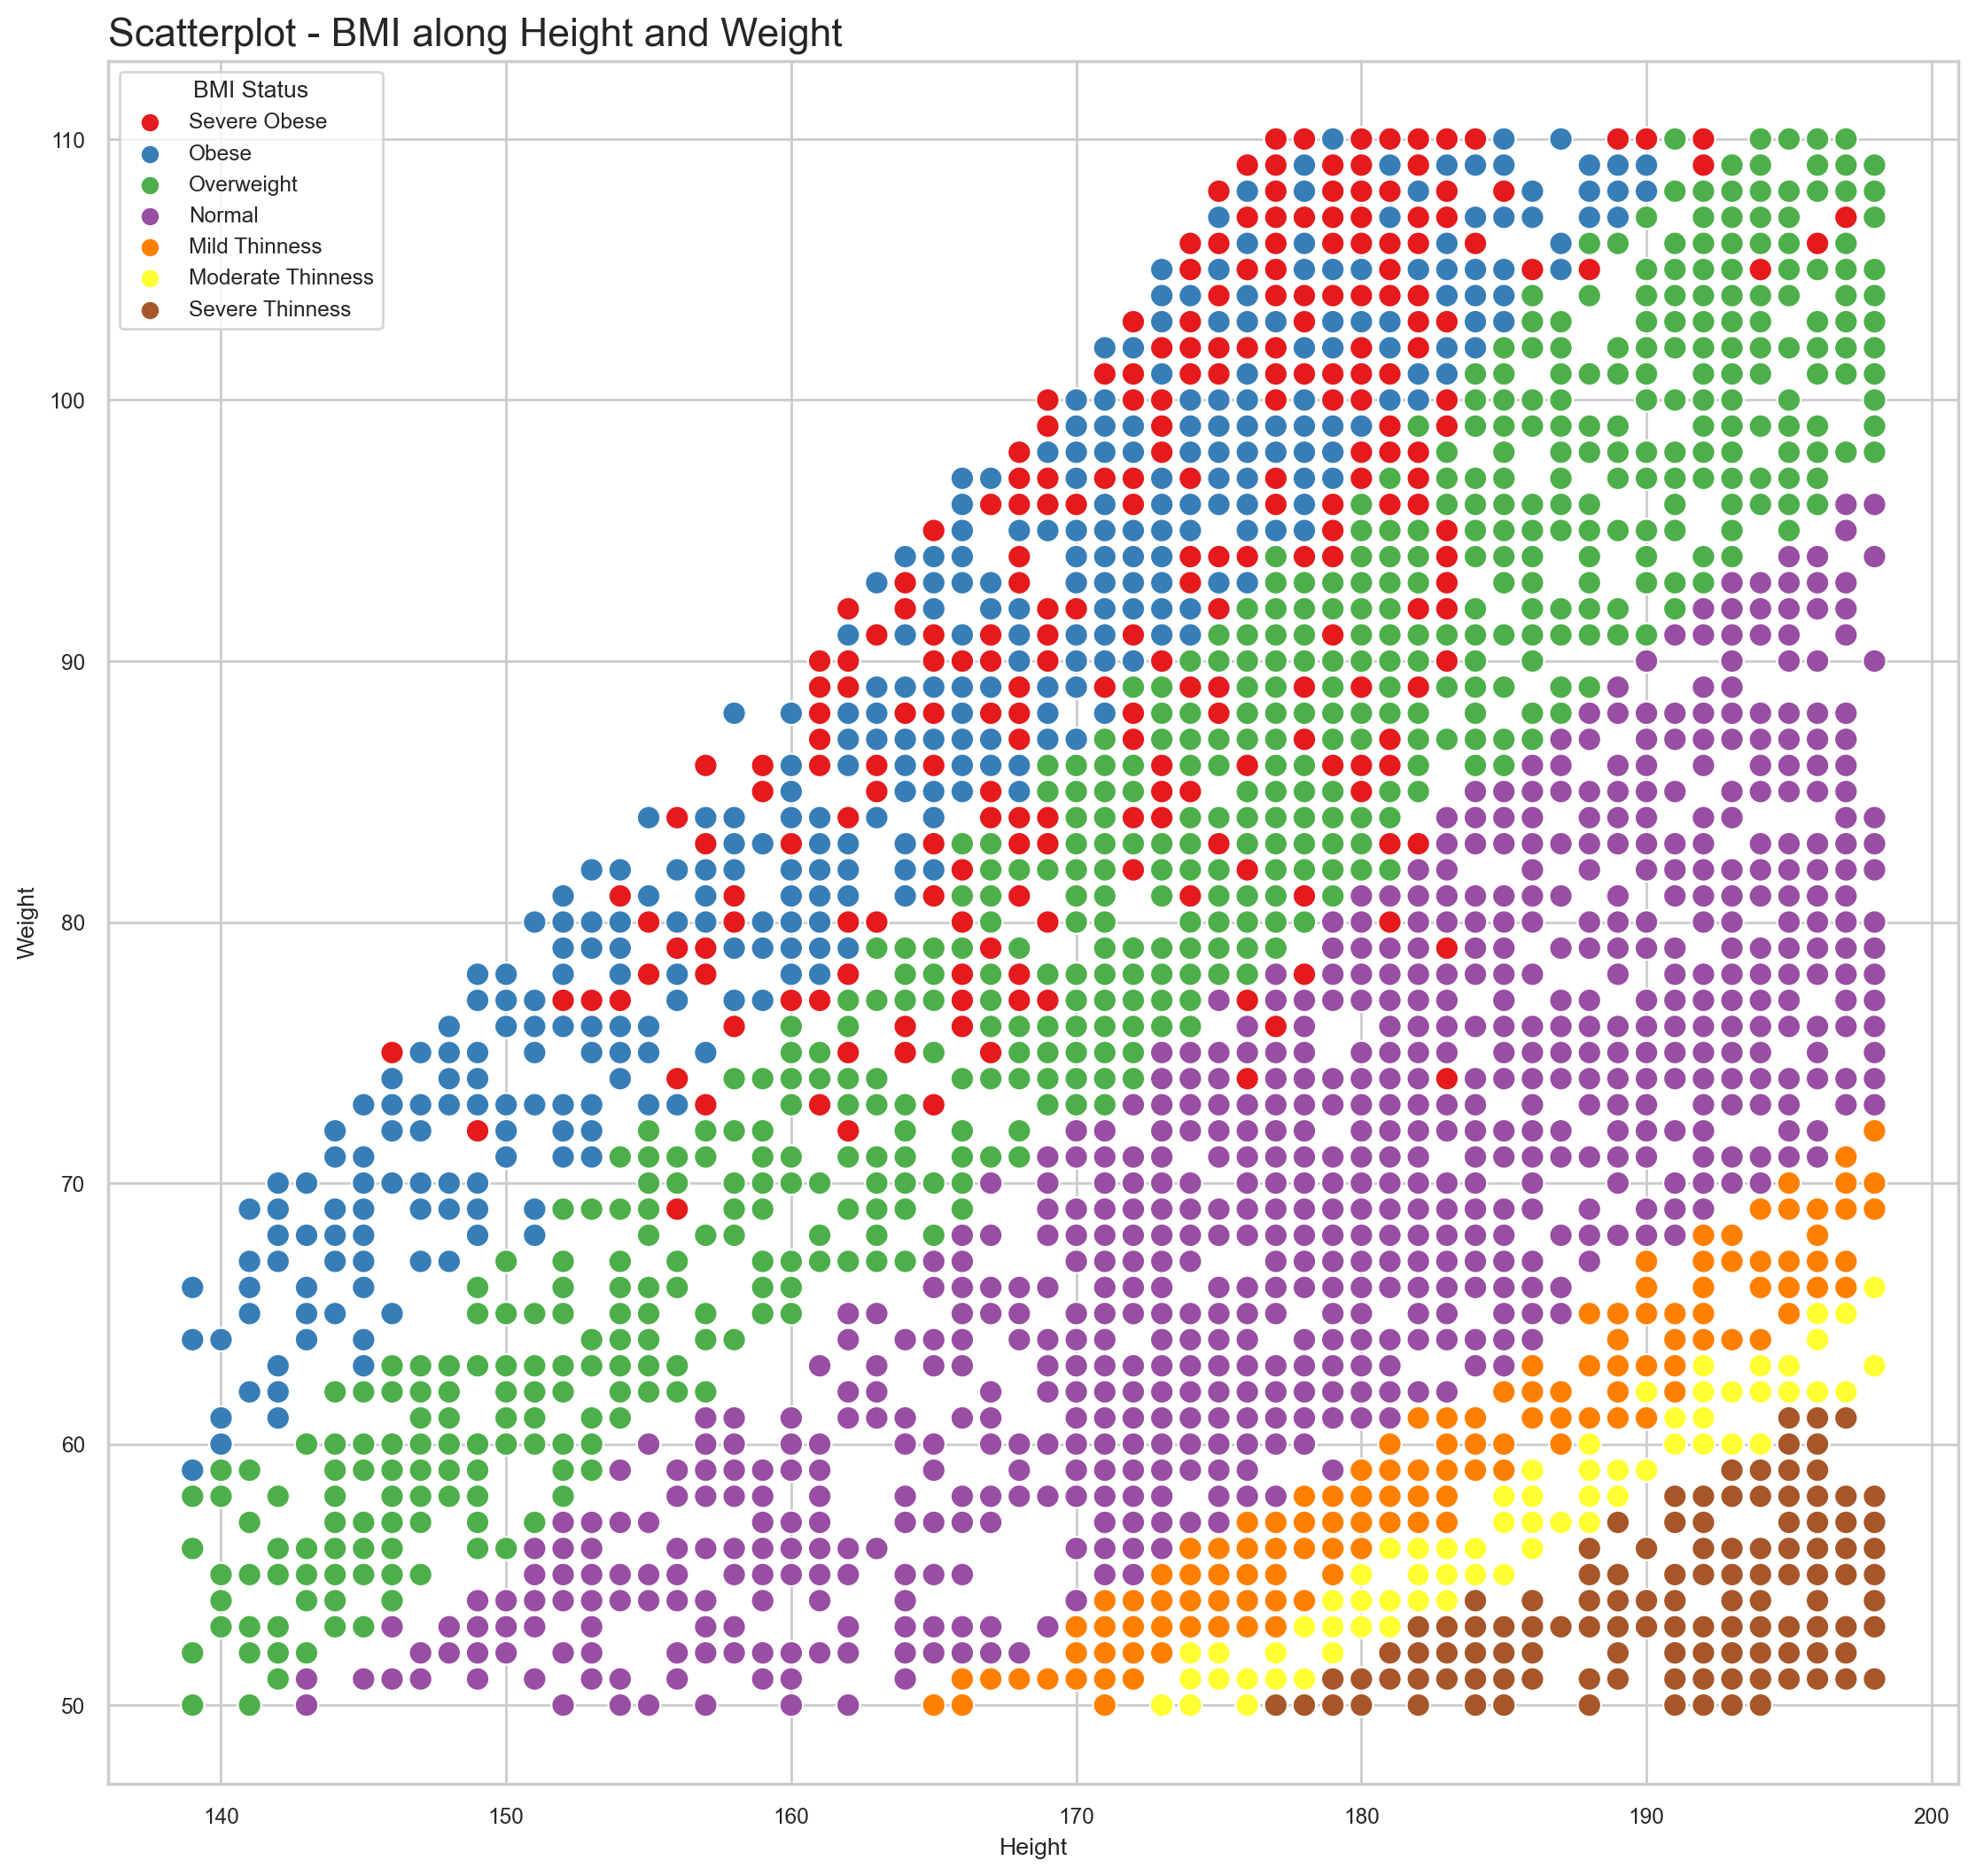

In [25]:
# plot scatterplot about BMI along height and weight
sns.set_style('whitegrid')

plt.figure(figsize=(12, 12))
plt.title('Scatterplot - BMI along Height and Weight', loc='left', fontsize = 16)
ax = sns.scatterplot(x='Height', y='Weight', data=df, hue='BMI_Status', palette='Set1', s = 90)

legend_labels = ['Severe Obese', 'Obese', 'Overweight', 'Normal', 'Mild Thinness', 'Moderate Thinness', 'Severe Thinness']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, loc = 'upper left', bbox_to_anchor=(0, 1), title = 'BMI Status')

plt.show()

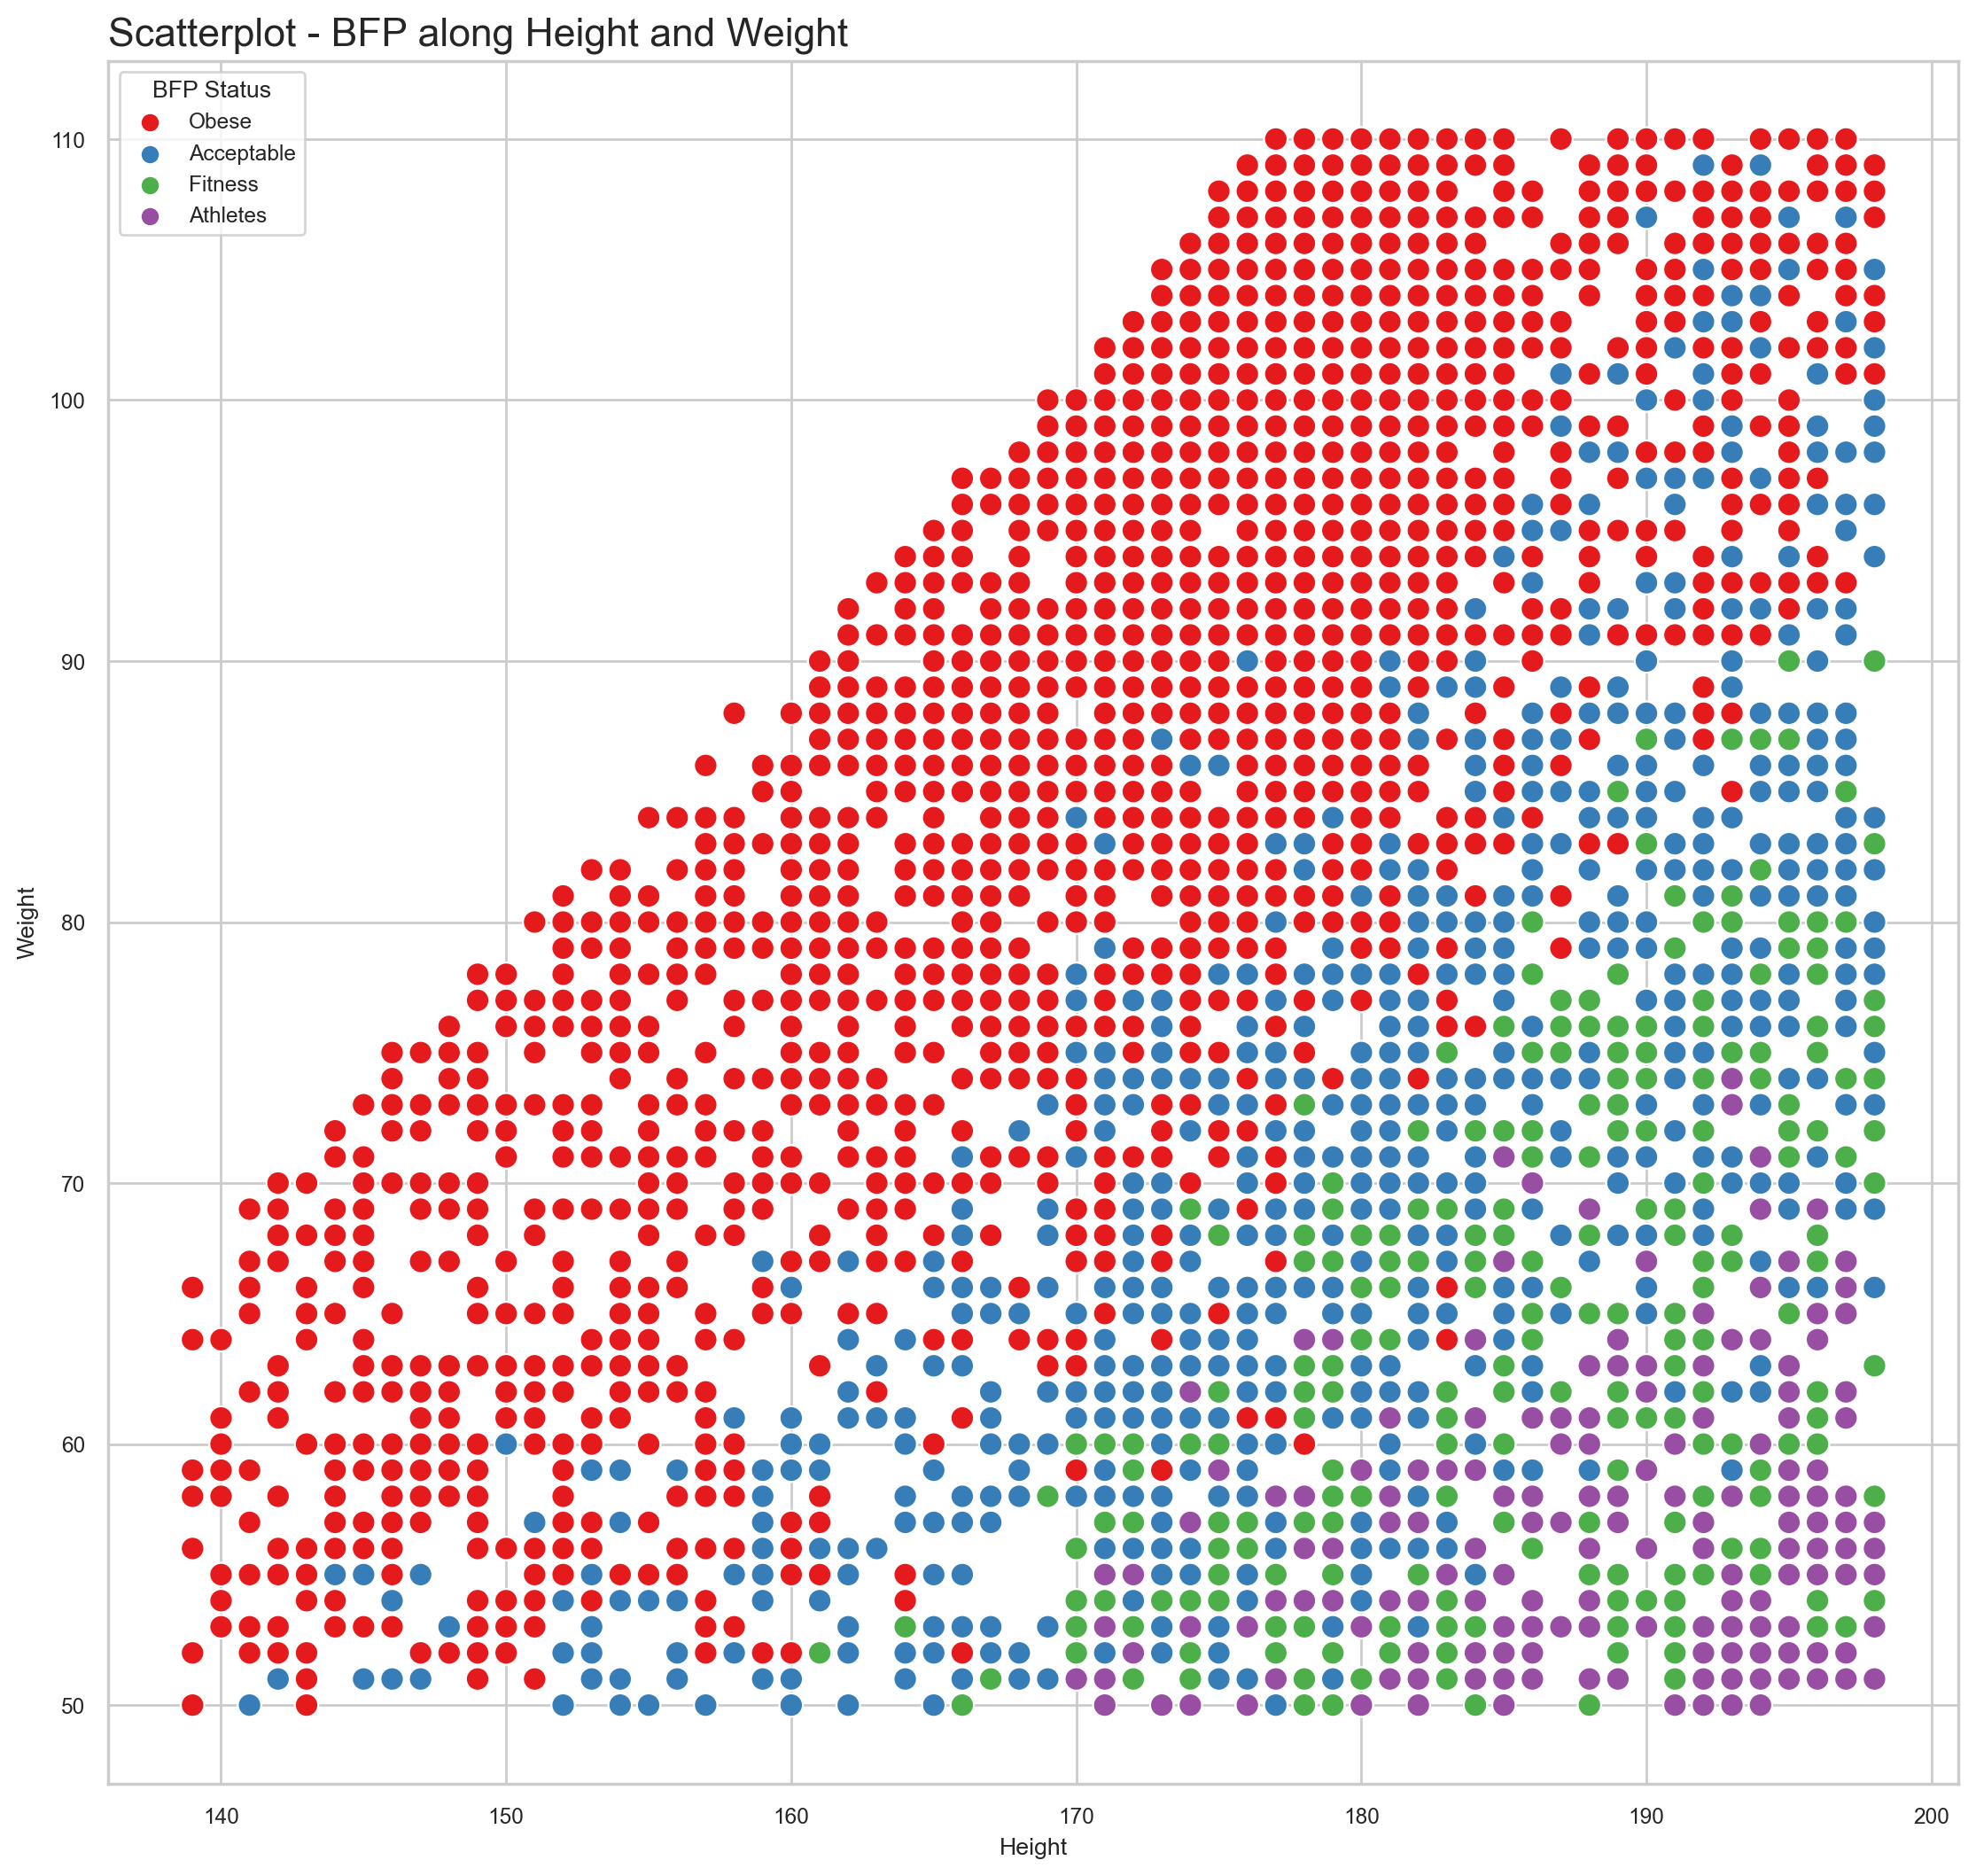

In [26]:
# plot scatterplot about BFP along height and weight
sns.set_style('whitegrid')

plt.figure(figsize=(12, 12))
plt.title('Scatterplot - BFP along Height and Weight', loc='left', fontsize = 16)
ax = sns.scatterplot(x='Height', y='Weight', data=df, hue='BFP_Status', palette='Set1', s = 90)

legend_labels = ['Obese', 'Acceptable', 'Fitness', 'Athletes']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, loc = 'upper left', bbox_to_anchor=(0, 1), title = 'BFP Status')

plt.show()

## Modelling

**BMI_Status** will be the target variable.

In [27]:
# define target and predictors
y = df.pop('BMI_Status')
X = df

In [28]:
# determine baseline accuracy
print('Baseline accuracy:', y.value_counts(normalize=True).max())
print()

Baseline accuracy: 0.2916



In [29]:
# split the data into a train and a hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [30]:
# instantiate a standar scaler, fit on the train set, and transform both the train and test sets.
# I only fit on the train set, so that the test set remains 'unseen' data.

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Random Forest Classifier  

Since my target is categorical, I need to fit a classification model.

  
  <br/><br/>

In [31]:
# instantiate the model
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=0)

# fit the model
rfc.fit(X_train, y_train)

# calculate the scores
rfc_train = rfc.score(X_train, y_train)
rfc_test = rfc.score(X_test, y_test)
rfc_cv = (cross_val_score(rfc, X_train, y_train, cv = 10)).mean()

rfc_predictions_train = rfc.predict(X_train)
rfc_predictions = rfc.predict(X_test)

# score the model
print('Random Forest Classifier \n')
print('Train score:          ', rfc_train)
print('Test score:           ', rfc_test)
print('Cross-val mean score: ', rfc_cv)

Random Forest Classifier 

R-squared train score:  0.997
R-squared test score:   0.81
R-squared CV score:     0.818


One way to understand the model is checking the score given to the different features, where this score represent the importance of each one.  
A higher score means that the specific feature will have a larger effect on the model when predicting a certain variable.  

  <br/><br/>

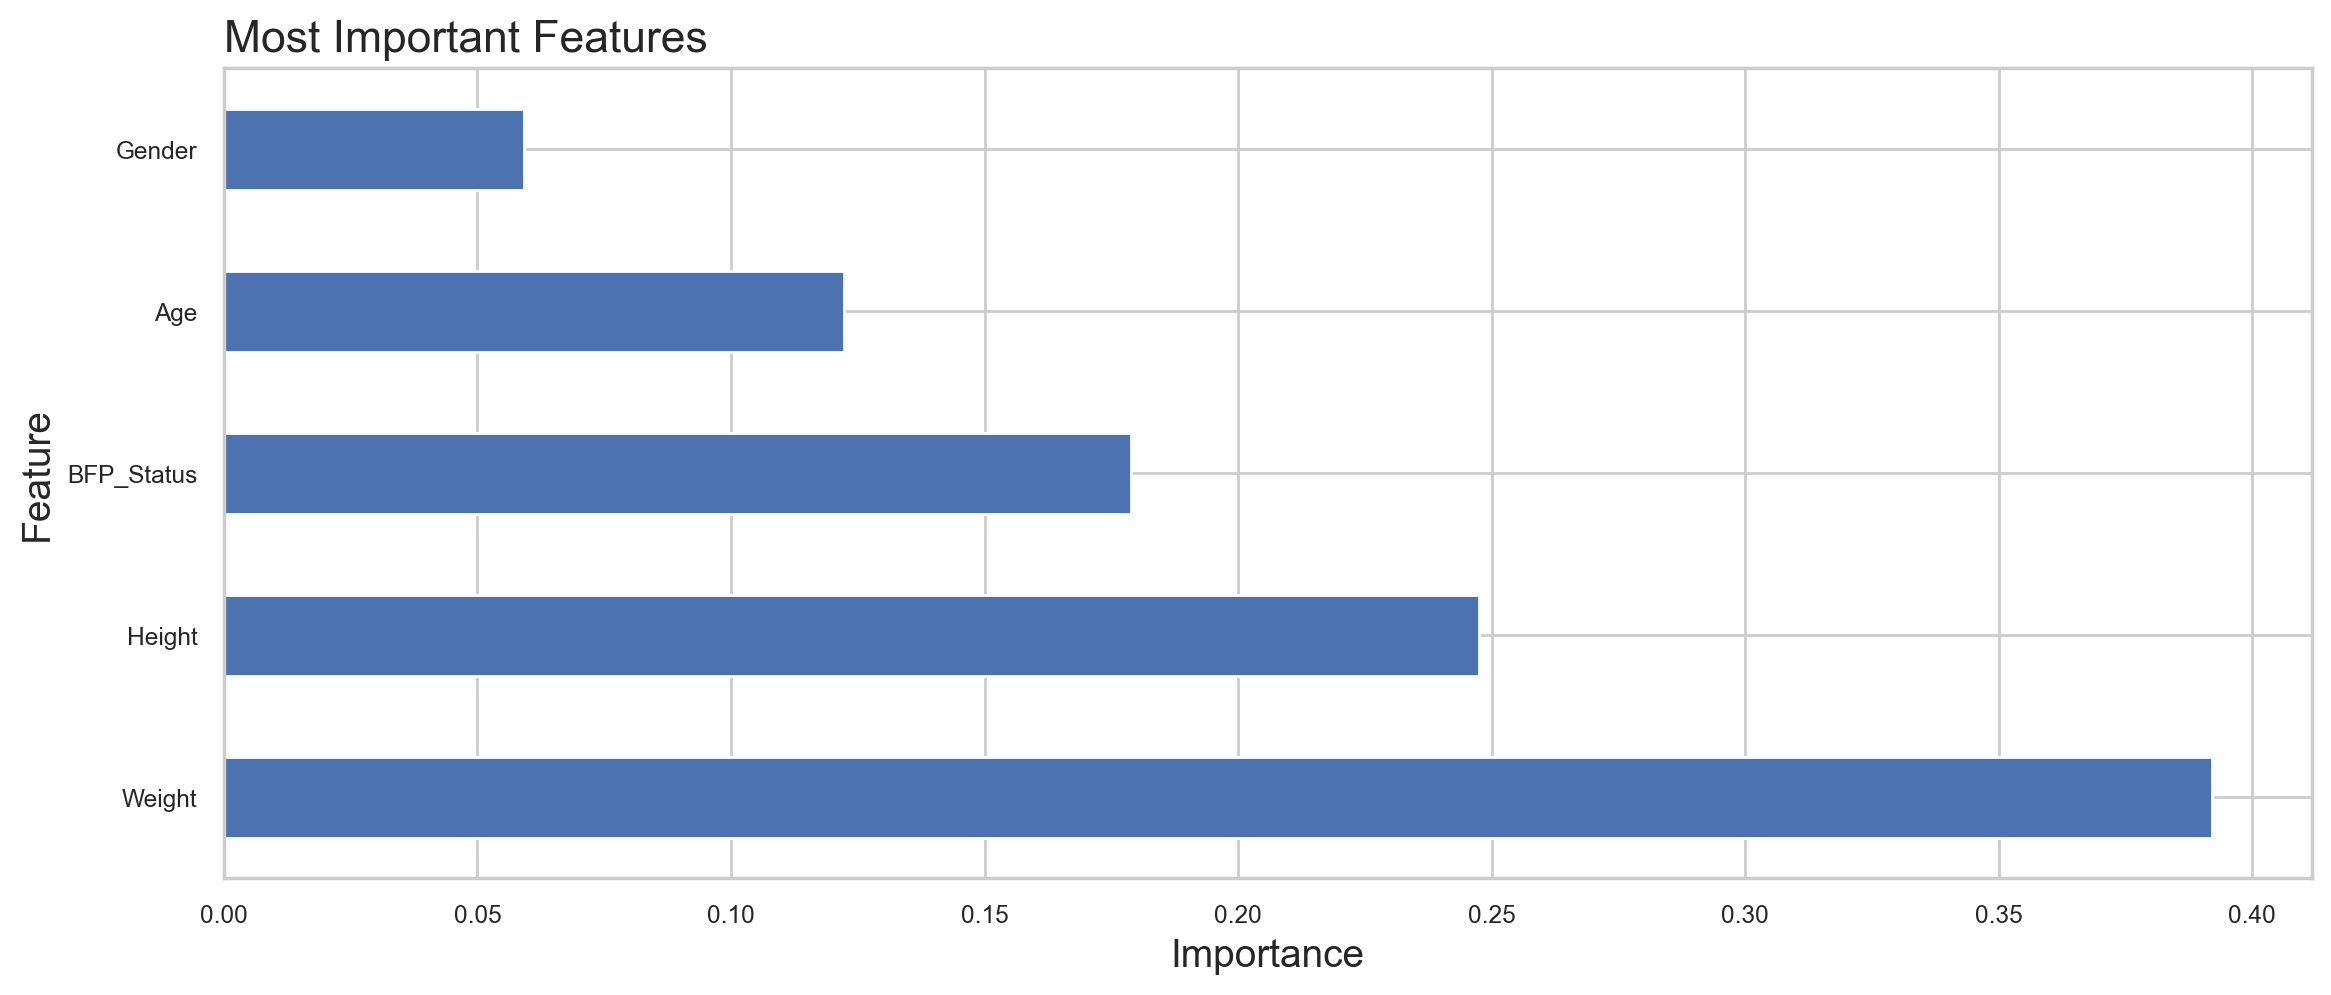

In [32]:
# plot barplot with most important features
plt.title('Most Important Features', loc='left', fontsize = 16)
plt.ylabel('Feature', fontsize = 14)
plt.xlabel('Importance', fontsize = 14)
(pd.Series(rfc.feature_importances_, index=X.columns)
   .nlargest()
   .plot(kind='barh', figsize=(12,5)));

### Model Evaluation

In [33]:
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

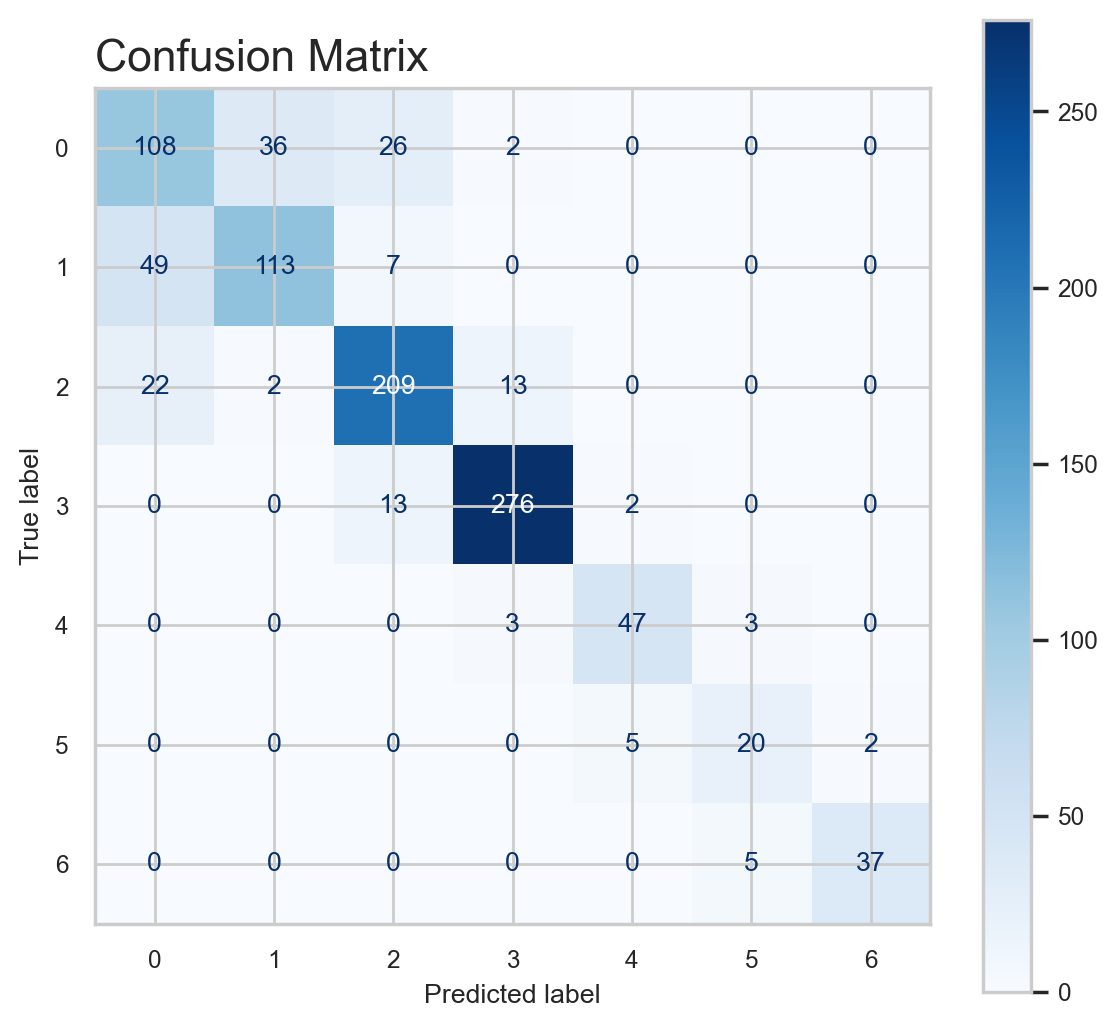

In [34]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(rfc, X_test, y_test, cmap='Blues', labels=[0, 1, 2, 3, 4, 5, 6], ax=ax)
plt.title('Confusion Matrix', loc='left', fontsize = 16)
plt.show()

In [35]:
print('Classification Report - Train \n')
print(classification_report(y_train, pred_train))

Classification Report - Train 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       688
           1       0.99      0.99      0.99       674
           2       1.00      1.00      1.00       984
           3       1.00      1.00      1.00      1167
           4       1.00      1.00      1.00       210
           5       1.00      1.00      1.00       108
           6       1.00      1.00      1.00       169

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [36]:
print('Classification Report - Test \n')
print(classification_report(y_test, pred_test))

Classification Report - Test 

              precision    recall  f1-score   support

           0       0.60      0.63      0.62       172
           1       0.75      0.67      0.71       169
           2       0.82      0.85      0.83       246
           3       0.94      0.95      0.94       291
           4       0.87      0.89      0.88        53
           5       0.71      0.74      0.73        27
           6       0.95      0.88      0.91        42

    accuracy                           0.81      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.81      0.81      1000



Function to test **BMI status** based on the above model.

In [37]:
# define function to test the model
def BMI_health_test(gender, age, height, weight, BFP_Status):
    '''Input gender as 0: Male/1: Female, height in cm, weight in Kg'''
    individual_data_dict = {'Gender':gender, 'Age':age, 'Height':height, 'Weight':weight, 'BFP_Status':BFP_Status}   
    individual_data = pd.DataFrame(data = individual_data_dict, index=[0])
    #individual_data.iloc[:,0] = lbl_enc.transform(individual_data.iloc[:,0])
    #individual_data = one_hot_enc_for_gender.transform(individual_data).toarray()
    df = pd.DataFrame(individual_data)
    df.iloc[:,:] = scaler.transform(df.iloc[:,:])
    pred_test = rfc.predict(individual_data)
    if pred_test == 0:
        return 'Severe Obese'
    elif pred_test == 1:
        return 'Obese'
    elif pred_test == 2:
        return 'Overweight'
    elif pred_test == 3:
        return 'Normal'
    elif pred_test == 4:
        return 'Mild Thinness'
    elif pred_test == 5:
        return 'Moderate Thinness'
    elif pred_test == 6:
        return 'Severe Thinness'

In [38]:
# define sample
sample_person = [0, 35, 170, 70, 1]

In [39]:
# test the function
sample_result = BMI_health_test(*sample_person)
sample_result

'Normal'

In [43]:
def predict_BMI(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    
    pred_test = model.predict(df)
    
    if pred_test == 0:
        return 'Severe Obese'
    elif pred_test == 1:
        return 'Obese'
    elif pred_test == 2:
        return 'Overweight'
    elif pred_test == 3:
        return 'Normal'
    elif pred_test == 4:
        return 'Mild Thinness'
    elif pred_test == 5:
        return 'Moderate Thinness'
    elif pred_test == 6:
        return 'Severe Thinness'

In [44]:
# define sample
config = {
    'Gender'    : [0],  # 0-Male, 1-Female
    'Age'       : [35],
    'Height'    : [170],
    'Weight'    : [70],
    'BFP_Status': [1]  # 0-Obese, 1-Acceptable, 2-Fitness, 3-Athletes
}


In [46]:
predict_BMI(config, rfc)

'Normal'

### Model Export

We save this model using `joblib` in case we need to access it for future projects.

In [40]:
# save the trained model for future access
joblib.dump(rfc, 'app/model.pkl')

['app/model.pkl']

In [41]:
# load from file
with open('app/model.pkl', 'rb') as file:
    joblib_model = joblib.load(file)

In [42]:
# calculate the accuracy score and predict target values
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 81.00 %


In [48]:
# load the model from the saved file
pkl_filename = "app/model.pkl"
with open(pkl_filename, 'rb') as f_in:
    model = joblib.load(f_in)

predictValue = predict_BMI(config, model)
predictValue

'Normal'